# Case Study: Optimization for volumetric productivity (Wichmann2023)

Paper: Characterizing and utilizing oxygen-dependent promoters for efficient dynamic metabolic engineering

Doi: https://doi.org/10.1016/j.ymben.2023.04.006


In [1]:
### Import packages
import polars as pl
import pandas as pd
import numpy as np
import scipy as sp
import itertools

from IPython.display import display

# For storing DataFrames
import pickle

import sys
from os import getcwd
sys.path.append(getcwd())
import MultiStagePackage.OptMSPfunctions as msp
from MultiStagePackage.models import *

# For optimization
from pygmo import *

In [2]:
### Prepare data

# initial conditions
X_0 = 0.1    # gDW/L
S_0 = 100.0  # mmol/L => max theoret c atoms for production = 6 atoms * S_0 (e.g.=100) = 600 c-atoms => 85% = 510
P_0 = 0.0    # mmol/L
s = np.array([X_0, S_0, P_0])

# Indexing
X, S, P = (i for i in range(len(s)))
r_S, r_P, mu = (i for i in range(3))

## Models

If the models are not directly defined in the cell then the following order and number of models was used:

In [3]:
models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

### Event function 

In [4]:
def event_sub0(t,y):
    if(y[S] <= 0.001):
        return 0    # 0 that event triggers
    return 1

### Objective function for optimization

In [5]:
## 1.) Define objective (here volumetric productivity)
def volprod(simulation, indexes, initial_values, tstart, tend):
    return simulation[P]/(simulation[-2]-tstart)

## One-Stage fermentation dynamics and simulation output

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 24.0)",[1],8.149,6.924,-0.000,1.575,1,0.193,0.016,0.016
1,2,"(0.0, 24.0)",[2],16.952,0.906,0.000,161.872,1,9.549,1.619,1.619
2,3,"(0.0, 24.0)",[3],24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
3,4,"(0.0, 24.0)",[4],8.843,8.324,0.000,1.316,1,0.149,0.013,0.013
4,5,"(0.0, 24.0)",[5],21.463,0.362,0.000,180.446,1,8.407,1.804,1.804
5,6,"(0.0, 24.0)",[6],24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
1,2,"(0.0, 24.0)",[2],16.952,0.906,0.0,161.872,1,9.549,1.619,1.619


CPU times: user 1.56 s, sys: 95.9 ms, total: 1.65 s
Wall time: 1.48 s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

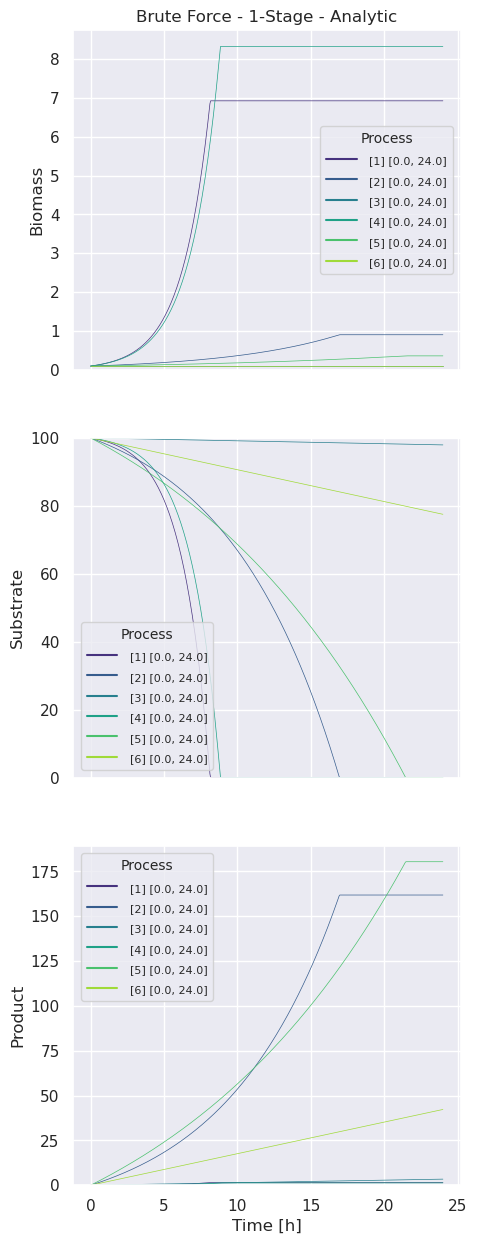

In [15]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 1
combis = [[0], [1], [2], [3], [4], [5]]

BruteForceAnalyt_1Stage = msp.do_brute_force_ana(combis=combis, 
                                                models=models_analytic, 
                                                n_stages=n_stages, 
                                                t_start=t_start, 
                                                t_end=t_end, 
                                                min_duration=min_duration, 
                                                s=s,
                                                indexes=[X,S,P])
display(BruteForceAnalyt_1Stage)

BruteForceAnalyt_1Stage_best = (BruteForceAnalyt_1Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalyt_1Stage_best)

msp.do_custom_plot(df=BruteForceAnalyt_1Stage, models_num=models_numeric, s=s, title="Brute Force - 1-Stage - Analytic", events=[event_sub0])

___

# Brute Force

## Two-Stage fermentation  - Analytic
(could be seen as strain comparison)

With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.149,6.924,-0.000,1.575,2,0.193,0.016,0.016
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
547,548,"(0.0, 22.0, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
548,549,"(0.0, 22.25, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
549,550,"(0.0, 22.5, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
550,551,"(0.0, 22.75, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
45,46,"(0.0, 4.75, 24.0)","[1, 2]",8.237,1.86,0.0,136.451,2,16.565,1.365,1.365


CPU times: user 827 ms, sys: 185 ms, total: 1.01 s
Wall time: 794 ms


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

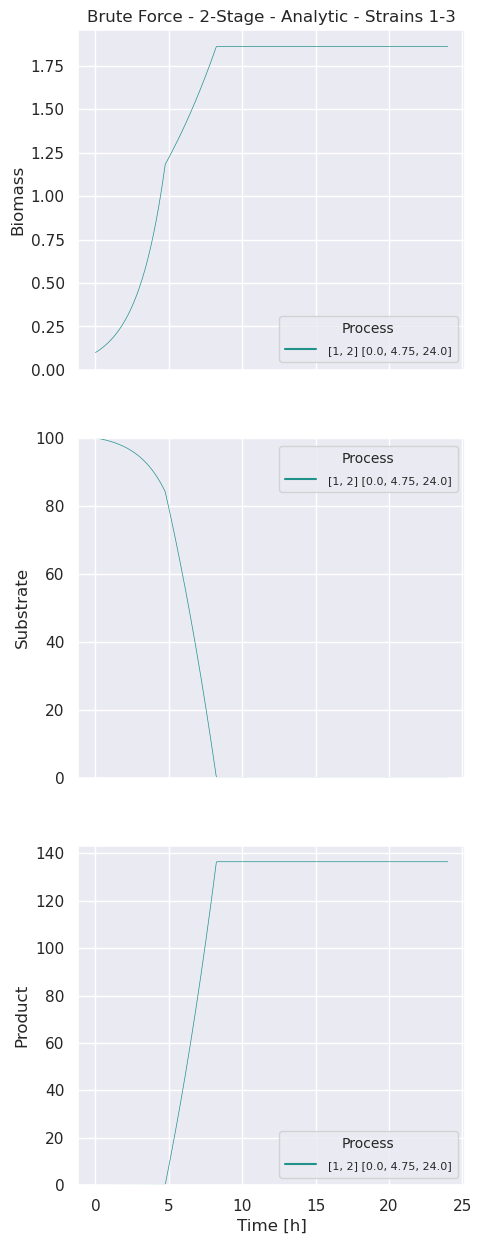

In [16]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2]))  

BruteForceAnalytic_2Stage_Ecolac = msp.do_brute_force_ana(combis=combis, 
                                                        models=models_analytic,
                                                        n_stages=n_stages, 
                                                        t_start=t_start, 
                                                        t_end=t_end, 
                                                        min_duration=min_duration, 
                                                        s=s,
                                                        density=den,
                                                        indexes=[X,S,P])
                                                            
display(BruteForceAnalytic_2Stage_Ecolac)
#msp.do_save(BruteForceAnalytic_2Stage_Ecolac, './Results/Computer_Stg2_ana_brf_1to3_den4.pickle')

BruteForceAnalytic_2Stage_Ecolac_best = (BruteForceAnalytic_2Stage_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_2Stage_Ecolac_best)
msp.do_custom_plot(df=BruteForceAnalytic_2Stage_Ecolac_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Analytic - Strains 1-3", events=[event_sub0])

In [17]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5]))  

BruteForceAnalytic_2Stage_EcolacATPase = msp.do_brute_force_ana(combis=combis, 
                                                                models=models_analytic,
                                                                n_stages=n_stages, 
                                                                t_start=t_start, 
                                                                t_end=t_end, 
                                                                min_duration=min_duration, 
                                                                s=s,
                                                                density=den,
                                                                indexes=[X,S,P])
display(BruteForceAnalytic_2Stage_EcolacATPase)
#msp.do_save(BruteForceAnalytic_2Stage_EcolacATPase, './Results/Computer_Stg2_ana_brf_4to6_den4.pickle')

BruteForceAnalytic_2Stage_EcolacATPase_best = (BruteForceAnalytic_2Stage_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_2Stage_EcolacATPase_best)

msp.do_custom_plot(df=BruteForceAnalytic_2Stage_EcolacATPase_best, models_num=models_numeric, s=s, title="Brute Force - 2-Stage - Analytic - Strains 4-6", events=[event_sub0])

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[4, 4]",8.843,8.324,0.000,1.316,2,0.149,0.013,0.013
1,2,"(0.0, 1.25, 24.0)","[4, 4]",8.843,8.324,0.000,1.316,2,0.149,0.013,0.013
2,3,"(0.0, 1.5, 24.0)","[4, 4]",8.843,8.324,0.000,1.316,2,0.149,0.013,0.013
3,4,"(0.0, 1.75, 24.0)","[4, 4]",8.843,8.324,0.000,1.316,2,0.149,0.013,0.013
4,5,"(0.0, 2.0, 24.0)","[4, 4]",8.843,8.324,0.000,1.316,2,0.149,0.013,0.013
...,...,...,...,...,...,...,...,...,...,...,...
610,611,"(0.0, 22.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
611,612,"(0.0, 22.25, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
612,613,"(0.0, 22.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
613,614,"(0.0, 22.75, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
48,49,"(0.0, 4.75, 24.0)","[4, 5]",7.998,1.306,0.0,159.206,2,19.905,1.592,1.592


## Two-Stage fermentation  - Numeric
(could be seen as strain comparison)

With density = 4 in paper denoted as ($t_{step}$=0.25h)

### Ecolac

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
547,548,"(0.0, 22.0, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
548,549,"(0.0, 22.25, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
549,550,"(0.0, 22.5, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
550,551,"(0.0, 22.75, 24.0)","[3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
45,46,"(0.0, 4.75, 24.0)","[1, 2]",8.237,1.86,0.0,136.45,2,16.565,1.364,1.365


CPU times: user 1min 7s, sys: 173 ms, total: 1min 7s
Wall time: 1min 7s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

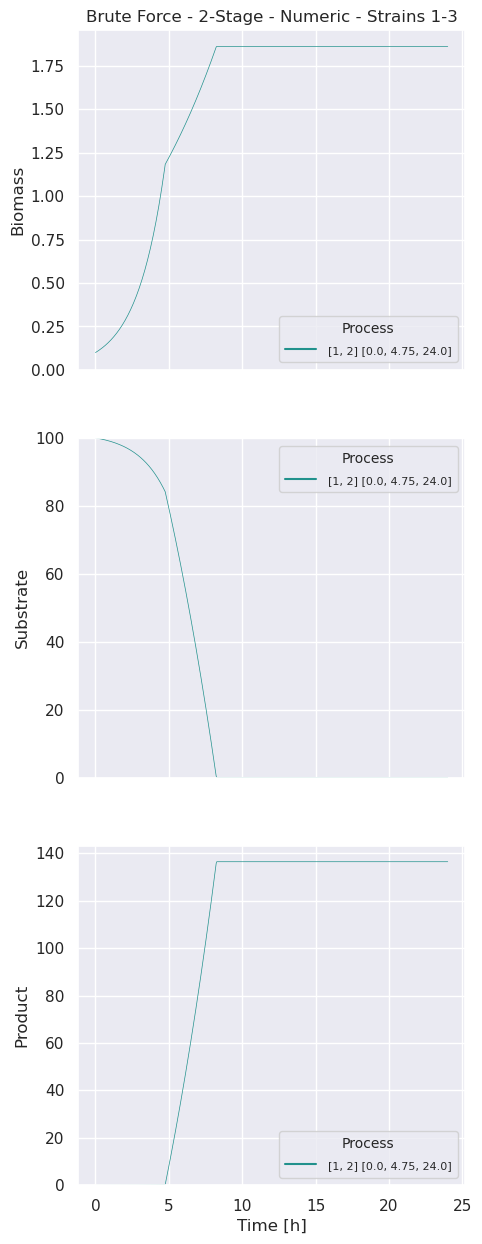

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2]))  

BruteForceNumeric_2Stage_Ecolac = msp.do_brute_force_num(combis=combis, 
                                                        models=models_numeric, 
                                                        n_stages=n_stages, 
                                                        t_start=t_start, 
                                                        t_end=t_end, 
                                                        min_duration=min_duration, 
                                                        s=s, 
                                                        events=[event_sub0],
                                                        density=den,
                                                        indexes=[X,S,P])
display(BruteForceNumeric_2Stage_Ecolac)
#msp.do_save(BruteForceNumeric_2Stage_Ecolac, './Results/Computer_Stg2_num_brf_1to3_den4.pickle')

BruteForceNumeric_2Stage_Ecolac_best = (BruteForceNumeric_2Stage_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_2Stage_Ecolac_best)

msp.do_custom_plot(df=BruteForceNumeric_2Stage_Ecolac_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 2-Stage - Numeric - Strains 1-3", 
                    events=[event_sub0],
                    indexes=[X,S,P])

### EcolacATPase

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[4, 4]",8.843,8.324,0.001,1.316,2,0.149,0.013,0.013
1,2,"(0.0, 1.25, 24.0)","[4, 4]",8.843,8.324,0.001,1.316,2,0.149,0.013,0.013
2,3,"(0.0, 1.5, 24.0)","[4, 4]",8.843,8.324,0.001,1.316,2,0.149,0.013,0.013
3,4,"(0.0, 1.75, 24.0)","[4, 4]",8.843,8.324,0.001,1.316,2,0.149,0.013,0.013
4,5,"(0.0, 2.0, 24.0)","[4, 4]",8.843,8.324,0.001,1.316,2,0.149,0.013,0.013
...,...,...,...,...,...,...,...,...,...,...,...
610,611,"(0.0, 22.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
611,612,"(0.0, 22.25, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
612,613,"(0.0, 22.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
613,614,"(0.0, 22.75, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
48,49,"(0.0, 4.75, 24.0)","[4, 5]",7.998,1.306,0.001,159.205,2,19.905,1.592,1.592


CPU times: user 1min 17s, sys: 152 ms, total: 1min 17s
Wall time: 1min 17s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

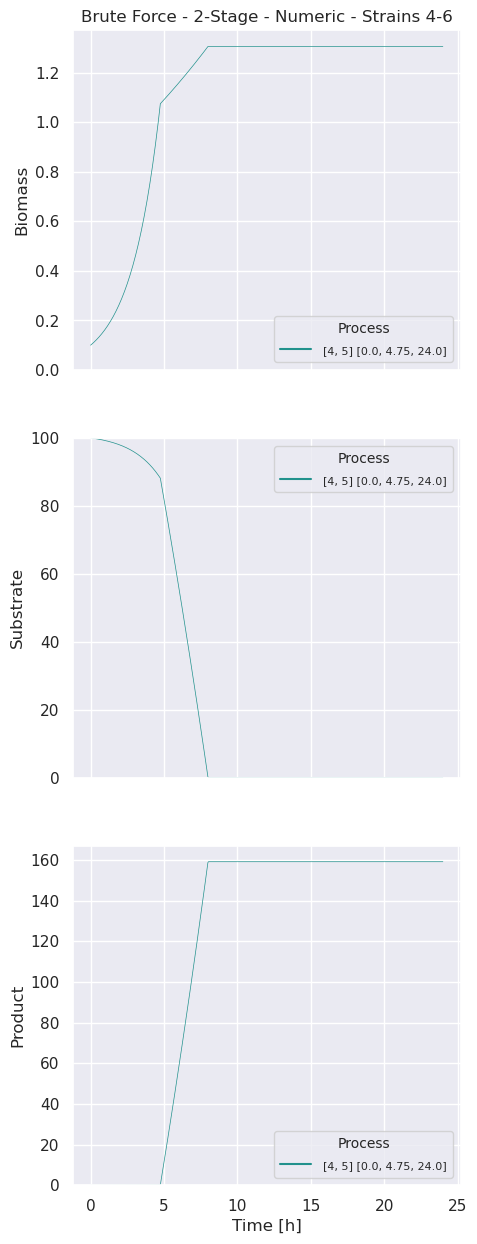

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5]))  

BruteForceNumeric_2Stage_EcolacATPase = msp.do_brute_force_num(combis=combis, 
                                                                models=models_numeric, 
                                                                n_stages=n_stages, 
                                                                t_start=t_start, 
                                                                t_end=t_end, 
                                                                min_duration=min_duration, 
                                                                s=s, 
                                                                events=[event_sub0],
                                                                density=den,
                                                                indexes=[X,S,P])
display(BruteForceNumeric_2Stage_EcolacATPase)
#msp.do_save(BruteForceNumeric_2Stage_EcolacATPase, './Results/Computer_Stg2_num_brf_4to6_den4.pickle')

BruteForceNumeric_2Stage_EcolacATPase_best = (BruteForceNumeric_2Stage_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_2Stage_EcolacATPase_best)

msp.do_custom_plot(df=BruteForceNumeric_2Stage_EcolacATPase_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 2-Stage - Numeric - Strains 4-6",
                    events=[event_sub0],
                    indexes=[X,S,P])

## Two-Stage fermentation (all modules)  - Analytic

With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.149,6.924,-0.000,1.575,2,0.193,0.016,0.016
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.149,6.924,0.000,1.575,2,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
134,135,"(0.0, 4.5, 24.0)","[1, 5]",7.788,1.265,0.0,155.857,2,20.013,1.559,1.559


CPU times: user 1.16 s, sys: 176 ms, total: 1.34 s
Wall time: 1.12 s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

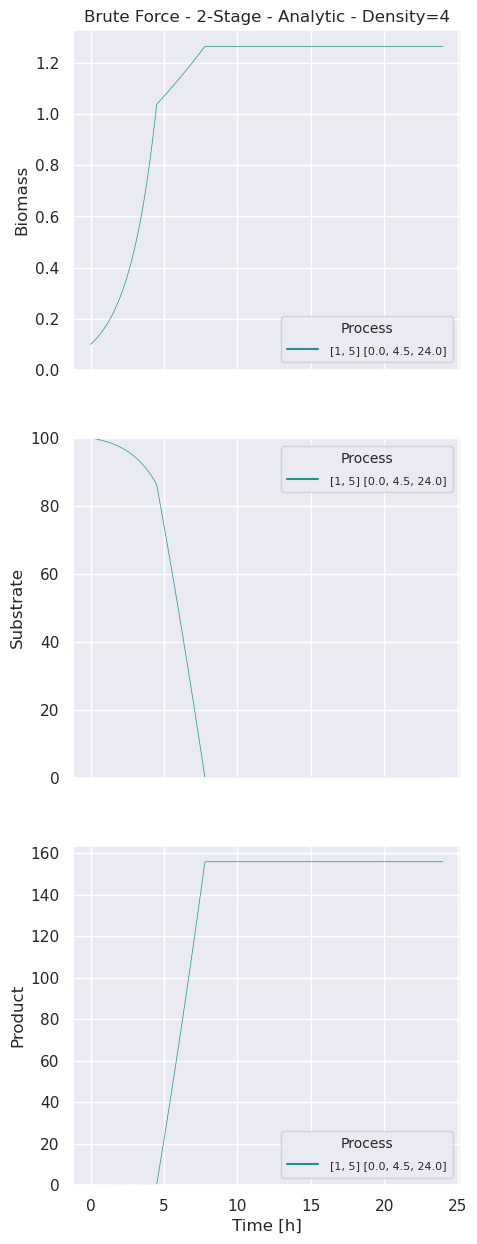

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceAnalytic_2Stage_den4 = msp.do_brute_force_ana(combis=combis, 
                                                        models=models_analytic, 
                                                        n_stages=n_stages, 
                                                        t_start=t_start, 
                                                        t_end=t_end, 
                                                        min_duration=min_duration, 
                                                        s=s, 
                                                        density=den,
                                                        indexes=[X,S,P])
display(BruteForceAnalytic_2Stage_den4)

BruteForceAnalytic_2Stage_den4_best = (BruteForceAnalytic_2Stage_den4.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_2Stage_den4_best)
msp.do_custom_plot(df=BruteForceAnalytic_2Stage_den4_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 2-Stage - Analytic - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

## Two-Stage fermentation (all modules) - Numeric 

With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
1,2,"(0.0, 1.25, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
2,3,"(0.0, 1.5, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
3,4,"(0.0, 1.75, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
4,5,"(0.0, 2.0, 24.0)","[1, 1]",8.149,6.924,0.001,1.575,2,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
134,135,"(0.0, 4.5, 24.0)","[1, 5]",7.788,1.265,0.001,155.855,2,20.013,1.559,1.559


CPU times: user 4min 53s, sys: 188 ms, total: 4min 53s
Wall time: 4min 53s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

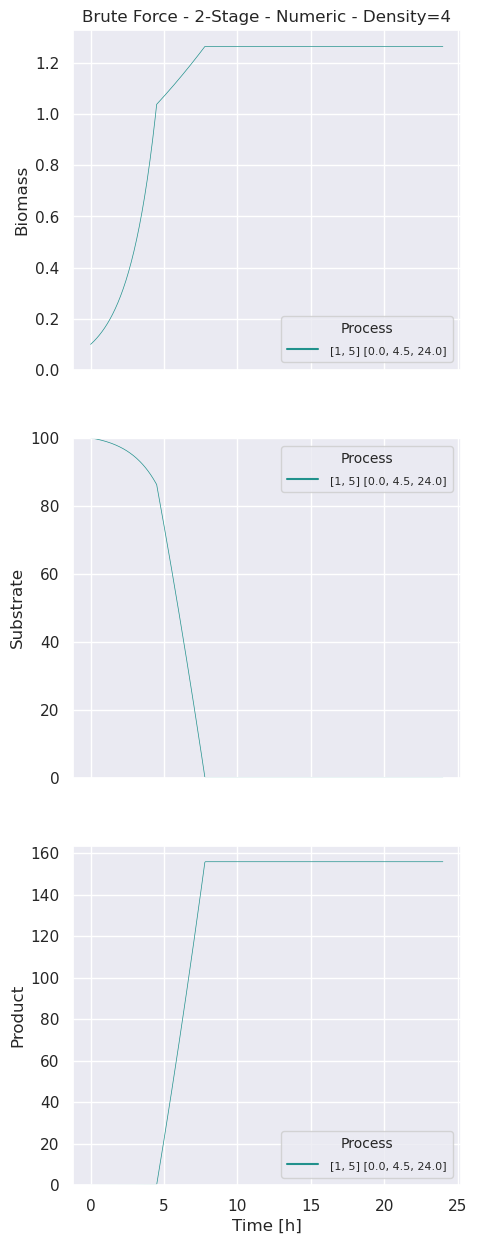

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
den = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceNumeric_2Stage = msp.do_brute_force_num(combis=combis, 
                                                        models=models_numeric, 
                                                        n_stages=n_stages, 
                                                        t_start=t_start, 
                                                        t_end=t_end, 
                                                        min_duration=min_duration, 
                                                        s=s, 
                                                        events=[event_sub0],
                                                        density=den,
                                                        indexes=[X,S,P])
display(BruteForceNumeric_2Stage)

BruteForceNumeric_2Stage_best = (BruteForceNumeric_2Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_2Stage_best)
msp.do_custom_plot(df=BruteForceNumeric_2Stage_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 2-Stage - Numeric - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

## Three-Stage fermentation  - Analytic
(could be seen as strain comparison)

With density = 4 in paper denoted as ($t_{step}$=0.25h)

### Ecolac

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.149,6.924,-0.000,1.575,3,0.193,0.016,0.016
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.149,6.924,0.000,1.575,3,0.193,0.016,0.016
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.149,6.924,0.000,1.575,3,0.193,0.016,0.016
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.149,6.924,0.000,1.575,3,0.193,0.016,0.016
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.149,6.924,-0.000,1.575,3,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
55312,55313,"(0.0, 21.5, 22.75, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
55313,55314,"(0.0, 21.5, 23.0, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
55314,55315,"(0.0, 21.75, 22.75, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
55315,55316,"(0.0, 21.75, 23.0, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
2040,2041,"(0.0, 4.75, 6.25, 24.0)","[1, 2, 2]",8.237,1.86,0.0,136.451,3,16.565,1.365,1.365


CPU times: user 8.85 s, sys: 192 ms, total: 9.04 s
Wall time: 8.82 s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

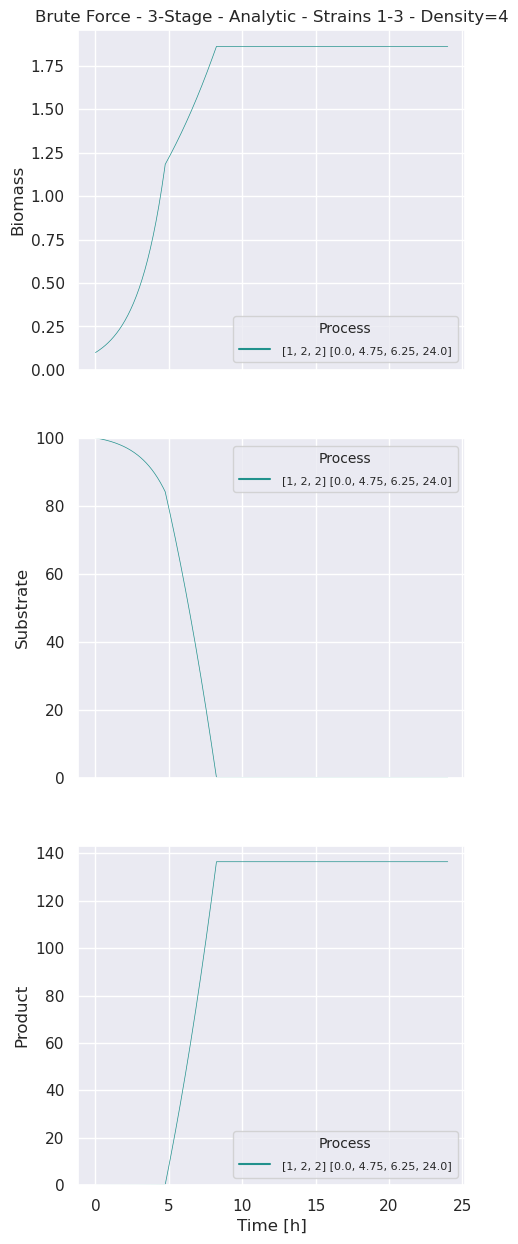

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2], [0, 1, 2]))  

BruteForceAnalytic_3Stage_Ecolac = msp.do_brute_force_ana(combis=combis, 
                                                                models=models_analytic, 
                                                                n_stages=n_stages, 
                                                                t_start=t_start, 
                                                                t_end=t_end, 
                                                                min_duration=min_duration, 
                                                                s=s, 
                                                                density=den,
                                                                indexes=[X,S,P])
display(BruteForceAnalytic_3Stage_Ecolac)

BruteForceAnalytic_3Stage_Ecolac_best = (BruteForceAnalytic_3Stage_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_3Stage_Ecolac_best)

msp.do_custom_plot(df=BruteForceAnalytic_3Stage_Ecolac_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 3-Stage - Analytic - Strains 1-3 - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

### EcolacATPase

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[4, 4, 4]",8.843,8.324,0.000,1.316,3,0.149,0.013,0.013
1,2,"(0.0, 1.0, 2.25, 24.0)","[4, 4, 4]",8.843,8.324,0.000,1.316,3,0.149,0.013,0.013
2,3,"(0.0, 1.0, 2.5, 24.0)","[4, 4, 4]",8.843,8.324,0.000,1.316,3,0.149,0.013,0.013
3,4,"(0.0, 1.0, 2.75, 24.0)","[4, 4, 4]",8.843,8.324,0.000,1.316,3,0.149,0.013,0.013
4,5,"(0.0, 1.0, 3.0, 24.0)","[4, 4, 4]",8.843,8.324,0.000,1.316,3,0.149,0.013,0.013
...,...,...,...,...,...,...,...,...,...,...,...
61246,61247,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
61247,61248,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
61248,61249,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
61249,61250,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
2359,2360,"(0.0, 4.75, 6.75, 24.0)","[4, 5, 5]",7.998,1.306,-0.0,159.206,3,19.905,1.592,1.592


CPU times: user 9.86 s, sys: 176 ms, total: 10 s
Wall time: 9.82 s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

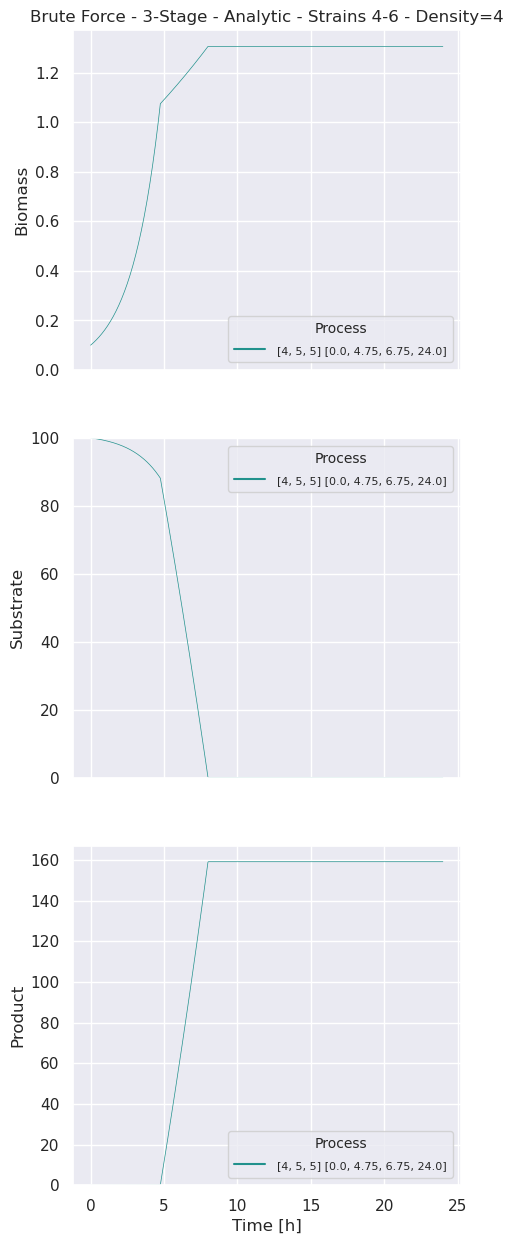

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5], [3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceAnalytic_3Stage_EcolacATPase = msp.do_brute_force_ana(combis=combis, 
                                                                models=models_analytic, 
                                                                n_stages=n_stages, 
                                                                t_start=t_start, 
                                                                t_end=t_end, 
                                                                min_duration=min_duration, 
                                                                s=s, 
                                                                density=den,
                                                                indexes=[X,S,P])
display(BruteForceAnalytic_3Stage_EcolacATPase)

BruteForceAnalytic_3Stage_EcolacATPase_best = (BruteForceAnalytic_3Stage_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_3Stage_EcolacATPase_best)

msp.do_custom_plot(df=BruteForceAnalytic_3Stage_EcolacATPase_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 3-Stage - Analytic - Strains 4-6 - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

## Three-Stage fermentation  - Numeric
(could be seen as strain comparison)

With density = 4 in paper denoted as ($t_{step}$=0.25h)

### Ecolac

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
55312,55313,"(0.0, 21.5, 22.75, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
55313,55314,"(0.0, 21.5, 23.0, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
55314,55315,"(0.0, 21.75, 22.75, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651
55315,55316,"(0.0, 21.75, 23.0, 24.0)","[3, 3, 3]",24.000,0.100,97.936,3.408,inf,0.142,0.034,1.651


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
2040,2041,"(0.0, 4.75, 6.25, 24.0)","[1, 2, 2]",8.237,1.86,0.0,136.45,3,16.565,1.364,1.365


CPU times: user 1h 59min 49s, sys: 172 ms, total: 1h 59min 49s
Wall time: 1h 59min 49s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

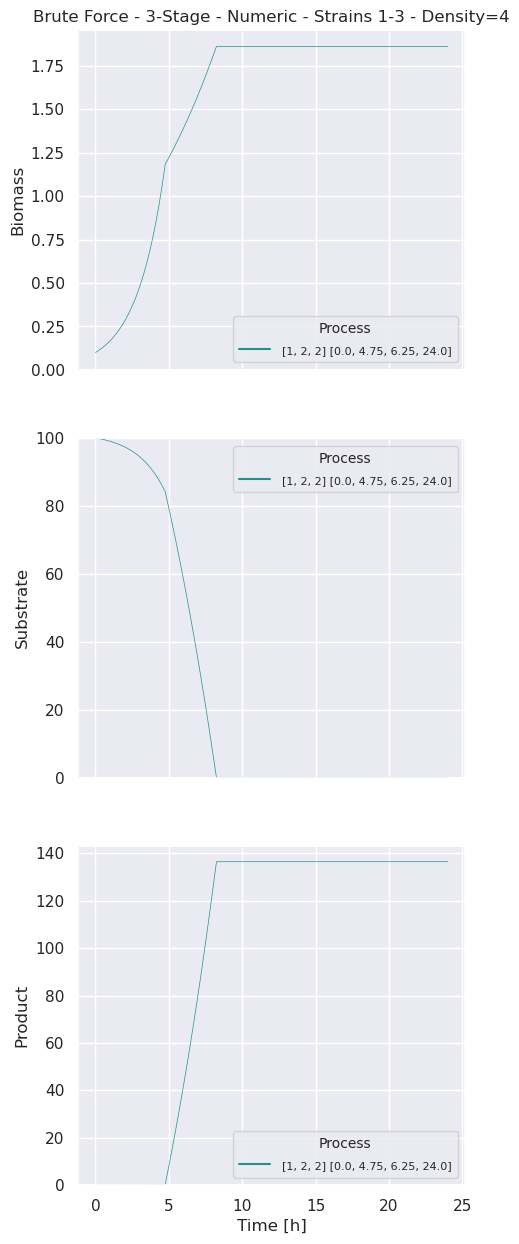

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([0, 1, 2], [0, 1, 2], [0, 1, 2])) 

BruteForceNumeric_3Stage_Ecolac = msp.do_brute_force_num(combis=combis, 
                                                        models=models_numeric, 
                                                        n_stages=n_stages, 
                                                        t_start=t_start, 
                                                        t_end=t_end, 
                                                        min_duration=min_duration, 
                                                        s=s, 
                                                        events=[event_sub0],
                                                        density= den,
                                                        indexes=[X,S,P])
display(BruteForceNumeric_3Stage_Ecolac)

BruteForceNumeric_3Stage_Ecolac_best = (BruteForceNumeric_3Stage_Ecolac.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_3Stage_Ecolac_best)

msp.do_custom_plot(df=BruteForceNumeric_3Stage_Ecolac_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 3-Stage - Numeric - Strains 1-3 - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

### EcolacATPase

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[4, 4, 4]",8.843,8.324,0.001,1.316,3,0.149,0.013,0.013
1,2,"(0.0, 1.0, 2.25, 24.0)","[4, 4, 4]",8.843,8.324,0.001,1.316,3,0.149,0.013,0.013
2,3,"(0.0, 1.0, 2.5, 24.0)","[4, 4, 4]",8.843,8.324,0.001,1.316,3,0.149,0.013,0.013
3,4,"(0.0, 1.0, 2.75, 24.0)","[4, 4, 4]",8.843,8.324,0.001,1.316,3,0.149,0.013,0.013
4,5,"(0.0, 1.0, 3.0, 24.0)","[4, 4, 4]",8.843,8.324,0.001,1.316,3,0.149,0.013,0.013
...,...,...,...,...,...,...,...,...,...,...,...
61246,61247,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
61247,61248,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
61248,61249,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
61249,61250,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
2359,2360,"(0.0, 4.75, 6.75, 24.0)","[4, 5, 5]",7.998,1.306,0.001,159.205,3,19.905,1.592,1.592


CPU times: user 2h 8min 13s, sys: 168 ms, total: 2h 8min 13s
Wall time: 2h 8min 13s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

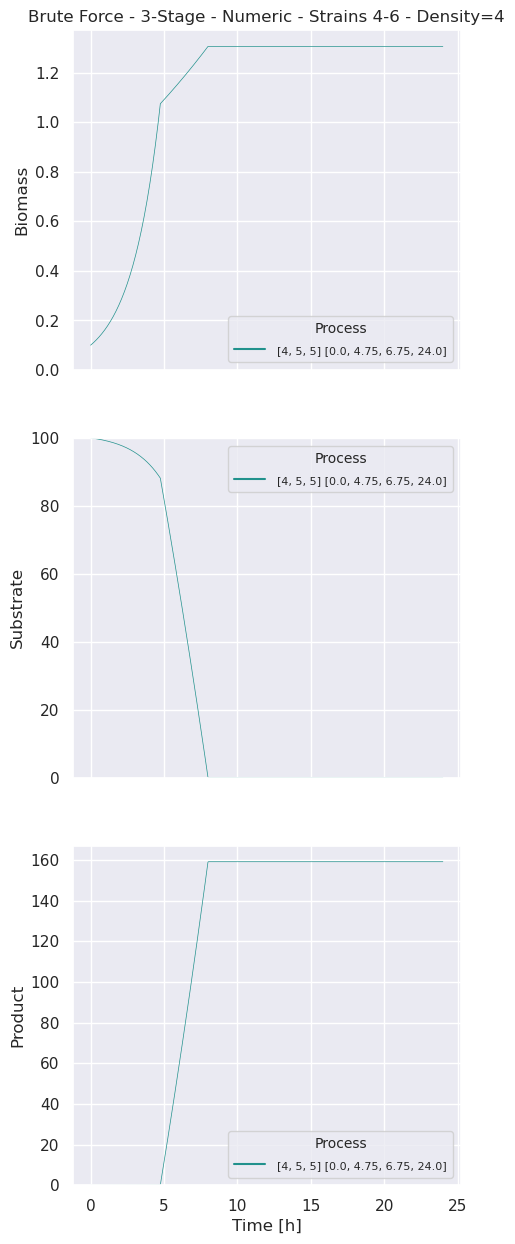

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([3, 4, 5], [3, 4, 5], [3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceNumeric_3Stage_EcolacATPase = msp.do_brute_force_num(combis=combis, 
                                                                models=models_numeric, 
                                                                n_stages=n_stages, 
                                                                t_start=t_start, 
                                                                t_end=t_end, 
                                                                min_duration=min_duration, 
                                                                s=s, 
                                                                events=[event_sub0],
                                                                density=den,
                                                                indexes=[X,S,P])
display(BruteForceNumeric_3Stage_EcolacATPase)

BruteForceNumeric_3Stage_EcolacATPase_best = (BruteForceNumeric_3Stage_EcolacATPase.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_3Stage_EcolacATPase_best)

msp.do_custom_plot(df=BruteForceNumeric_3Stage_EcolacATPase_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 3-Stage - Numeric - Strains 4-6 - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

## Three-Stage fermentation (all modules)  - Analytic

With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.149,6.924,-0.000,1.575,3,0.193,0.016,0.016
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.149,6.924,0.000,1.575,3,0.193,0.016,0.016
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.149,6.924,0.000,1.575,3,0.193,0.016,0.016
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.149,6.924,0.000,1.575,3,0.193,0.016,0.016
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.149,6.924,-0.000,1.575,3,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
464329,464330,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
464330,464331,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
464331,464332,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
464332,464333,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
18449,18450,"(0.0, 3.25, 4.75, 24.0)","[1, 4, 5]",7.749,1.373,-0.0,155.676,3,20.091,1.557,1.557


CPU times: user 1min 9s, sys: 268 ms, total: 1min 9s
Wall time: 1min 9s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

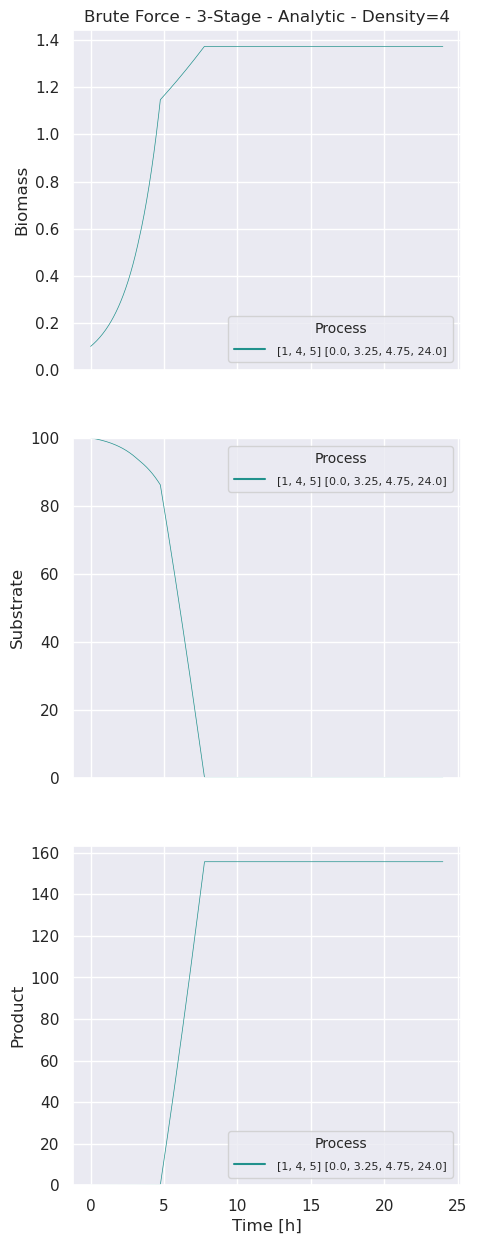

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den=4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceAnalytic_3Stage = msp.do_brute_force_ana(combis=combis, 
                                                    models=models_analytic, 
                                                    n_stages=n_stages, 
                                                    t_start=t_start, 
                                                    t_end=t_end, 
                                                    min_duration=min_duration, 
                                                    s=s, 
                                                    density=den,
                                                    indexes=[X,S,P])
display(BruteForceAnalytic_3Stage)

BruteForceAnalytic_3Stage_best = (BruteForceAnalytic_3Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceAnalytic_3Stage_best)

msp.do_custom_plot(df=BruteForceAnalytic_3Stage_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 3-Stage - Analytic - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

## Three-Stage fermentation (all modules)  - Numeric

With density = 4 in paper denoted as ($t_{step}$=0.25h)

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 2.0, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
1,2,"(0.0, 1.0, 2.25, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
2,3,"(0.0, 1.0, 2.5, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
3,4,"(0.0, 1.0, 2.75, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
4,5,"(0.0, 1.0, 3.0, 24.0)","[1, 1, 1]",8.149,6.924,0.001,1.575,3,0.193,0.016,0.016
...,...,...,...,...,...,...,...,...,...,...,...
464329,464330,"(0.0, 21.5, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
464330,464331,"(0.0, 21.5, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
464331,464332,"(0.0, 21.75, 22.75, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879
464332,464333,"(0.0, 21.75, 23.0, 24.0)","[6, 6, 6]",24.000,0.100,77.512,42.264,inf,1.761,0.423,1.879


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
18449,18450,"(0.0, 3.25, 4.75, 24.0)","[1, 4, 5]",7.749,1.373,0.001,155.674,3,20.091,1.557,1.557


CPU times: user 15h 26min 28s, sys: 492 ms, total: 15h 26min 29s
Wall time: 15h 26min 29s


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

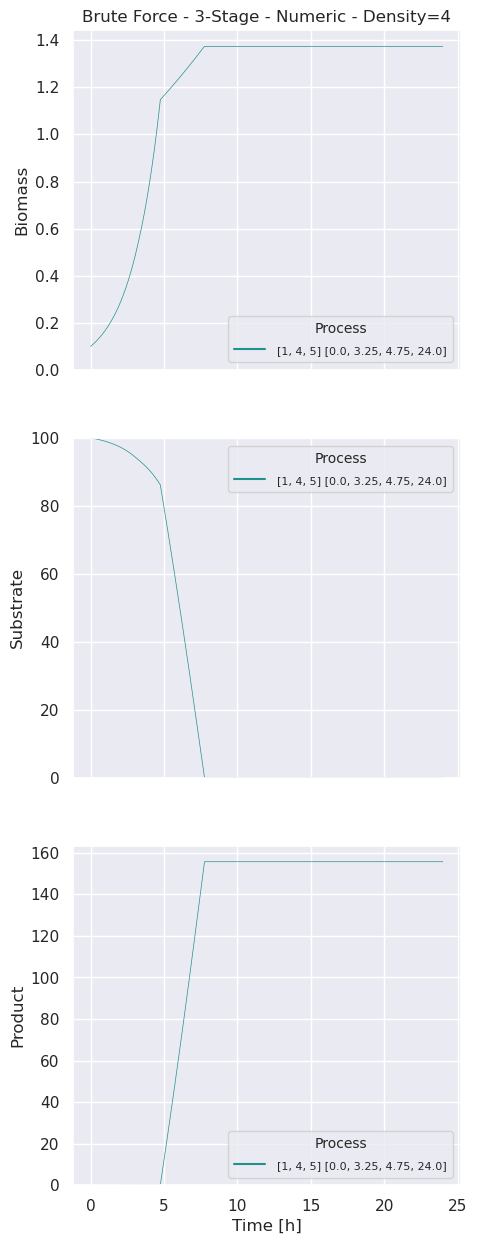

In [ ]:
%%time
t_start = 0
t_end = 24
min_duration = 1
n_stages = 3
den = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

BruteForceNumeric_3Stage = msp.do_brute_force_num(combis=combis, 
                                                    models=models_numeric, 
                                                    n_stages=n_stages, 
                                                    t_start=t_start, 
                                                    t_end=t_end, 
                                                    min_duration=min_duration, 
                                                    s=s, 
                                                    events=[event_sub0],
                                                    density = den,
                                                    indexes=[X,S,P])
display(BruteForceNumeric_3Stage)

BruteForceNumeric_3Stage_best = (BruteForceNumeric_3Stage.sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:1])
display(BruteForceNumeric_3Stage_best)

msp.do_custom_plot(df=BruteForceNumeric_3Stage_best, 
                    models_num=models_numeric, 
                    s=s, 
                    title="Brute Force - 3-Stage - Numeric - Density=4",
                    events=[event_sub0],
                    indexes=[X,S,P])

# Optimizer

## Two-Stage fermentation  - Analytic
(could be seen as strain comparison)

### Ecolac

In [6]:
%%time
models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt]

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest]

## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=5000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerAnalytic_2Stage_1to3_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_analytic,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.analytic_option
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerAnalytic_2Stage_1to3_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerAnalytic_2Stage_1to3 = algo_ihs.evolve(population(OptimizerAnalytic_2Stage_1to3_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerAnalytic_2Stage_1to3, './Results/Computer_Stg2_ana_opt_1to3.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350128         0.9977        3.87121        9.42197              0              0       -9.54862
    501       0.414128         0.3155              0              0              0              0       -16.5773
   1001       0.478128        0.09977              0              0              0              0       -16.5773
   1501       0.542128        0.03155              0              0              0              0       -16.5773
   2001       0.606128       0.009977      0.0157184    2.57551e-05              0              0        -16.578
   2501       0.670128       0.003155    0.000468119    7.31241e-07              0              0       -16.5781
   3001       0.734128      0.0009977    0.000431347    3.10387e-07              0              0       -16.5781
   3501       0.798128      0.0003155    0.000138348    2.57143e-08              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.632, 24.0]","[1, 2]",8.331,1.798,0.001,138.107,2,16.578,1.381,1.381


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

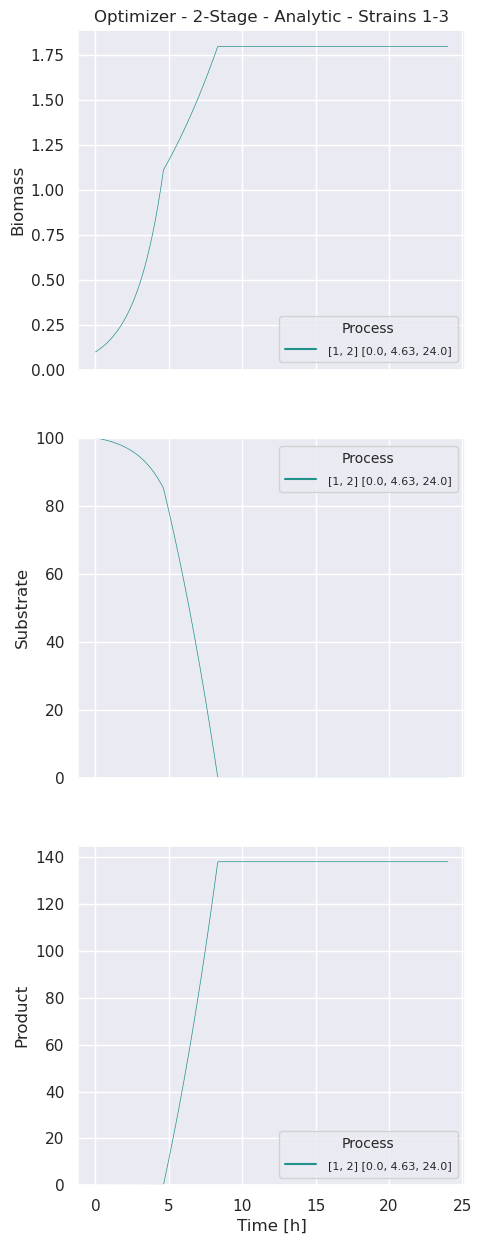

In [7]:
log_dataframe_2Stage_1to3 = pd.DataFrame(OptimizerAnalytic_2Stage_1to3.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerAnalytic_2Stage_1to3_best = msp.do_opt_to_df(  df=log_dataframe_2Stage_1to3,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerAnalytic_2Stage_1to3_best = msp.do_convert(opt_res=OptimizerAnalytic_2Stage_1to3_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerAnalytic_2Stage_1to3_best)

msp.do_custom_plot(df=df_OptimizerAnalytic_2Stage_1to3_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 2-Stage - Analytic - Strains 1-3",
                   events=[event_sub0])

### EcolacATPase

Modules below showing 1, 2, 3 but are if taken all modules in order 4, 5, 6

In [ ]:
%%time
models_analytic = [LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

models_numeric = [      LC_aerob_growth,
                        LC_anaerob_growth, 
                        LC_anaerob_growth_arrest]

## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=5000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation


## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerAnalytic_2Stage_4to6_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_analytic,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.analytic_option
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerAnalytic_2Stage_4to6_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerAnalytic_2Stage_4to6 = algo_ihs.evolve(population(OptimizerAnalytic_2Stage_4to6_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerAnalytic_2Stage_4to6, './Results/Computer_Stg2_ana_opt_4to6.pickle')



Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350128         0.9977        15.0652        10.3677              0              0       -11.8026
    501       0.414128         0.3155              0              0              0              0        -19.919
   1001       0.478128        0.09977              0              0              0              0        -19.919
   1501       0.542128        0.03155              0              0              0              0        -19.919
   2001       0.606128       0.009977              0              0              0              0       -19.9197
   2501       0.670128       0.003155     0.00359513    2.97343e-06              0              0       -19.9197
   3001       0.734128      0.0009977     0.00215478    1.48562e-06              0              0       -19.9197
   3501       0.798128      0.0003155    0.000119002    9.12972e-08              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.86, 24.0]","[1, 2]",7.926,1.366,0.001,157.875,2,19.92,1.579,1.579


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

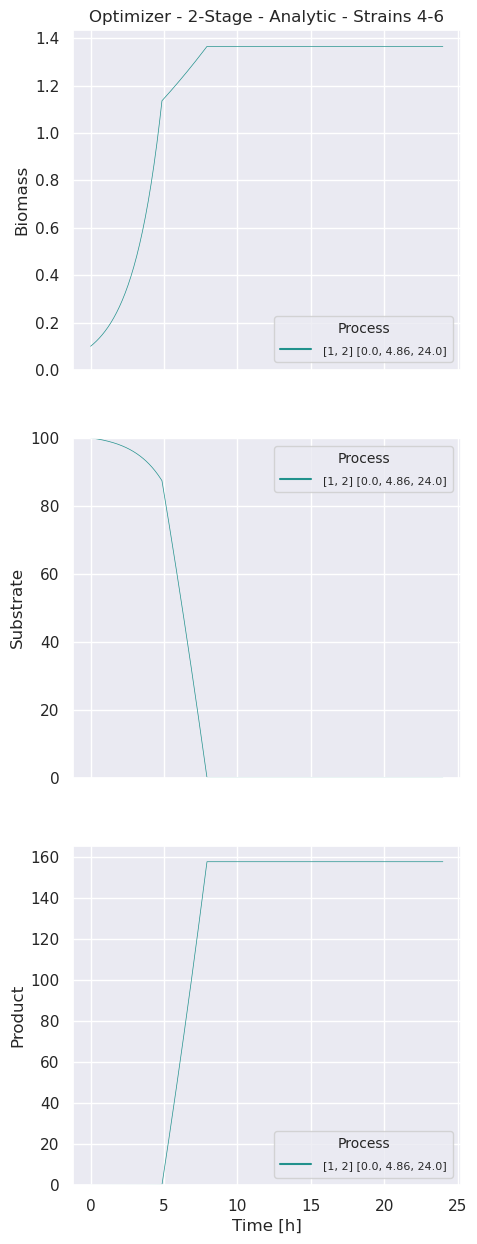

In [ ]:
log_dataframe_2Stage_4to6 = pd.DataFrame(OptimizerAnalytic_2Stage_4to6.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerAnalytic_2Stage_4to6_best = msp.do_opt_to_df(  df=log_dataframe_2Stage_4to6,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerAnalytic_2Stage_4to6_best = msp.do_convert(opt_res=OptimizerAnalytic_2Stage_4to6_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerAnalytic_2Stage_4to6_best)

msp.do_custom_plot(df=df_OptimizerAnalytic_2Stage_4to6_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 2-Stage - Analytic - Strains 4-6",
                   events=[event_sub0])


## Two-Stage fermentation  - Numeric
(could be seen as strain comparison)

### Ecolac

In [ ]:
%%time
models_numeric = [  WT_aerob_growth,
                    WT_anaerob_growth, 
                    WT_anaerob_growth_arrest]

## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=5000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerNumeric_2Stage_1to3_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.numeric_option,
            events=[event_sub0]
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerNumeric_2Stage_1to3_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerNumeric_2Stage_1to3 = algo_ihs.evolve(population(OptimizerNumeric_2Stage_1to3_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerNumeric_2Stage_1to3, './Results/Computer_Stg2_num_opt_1to3.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350128         0.9977        3.87121         9.4219              0              0       -9.54855
    501       0.414128         0.3155        0.13619      0.0159403              0              0       -16.5779
   1001       0.478128        0.09977              0              0              0              0       -16.5779
   1501       0.542128        0.03155              0              0              0              0       -16.5779
   2001       0.606128       0.009977      0.0112613    1.60256e-06              0              0       -16.5779
   2501       0.670128       0.003155              0              0              0              0       -16.5779
   3001       0.734128      0.0009977     0.00531239    1.68937e-05              0              0        -16.578
   3501       0.798128      0.0003155     0.00236619    3.30318e-07              0             

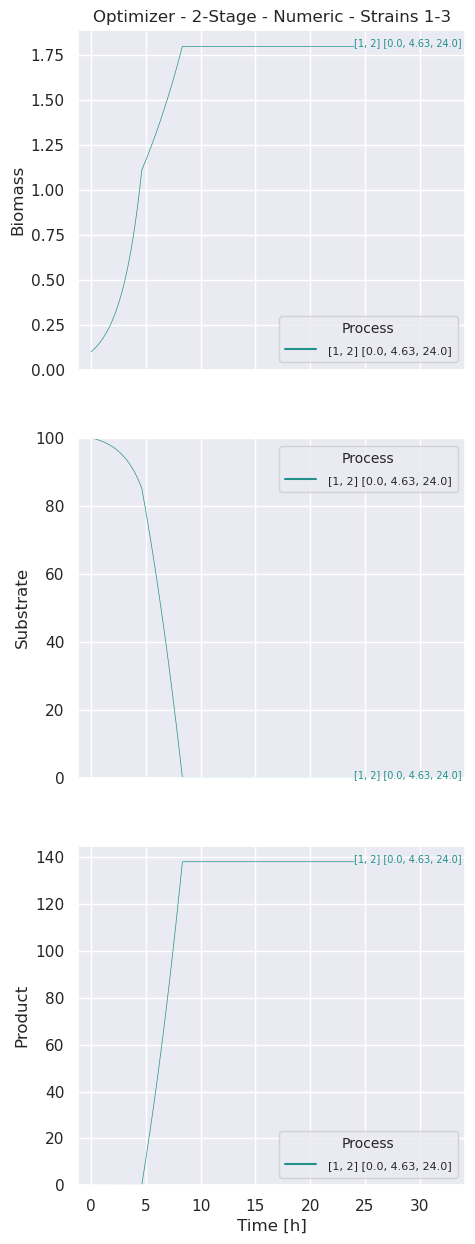

In [ ]:
log_dataframe_2Stage_1to3_num = pd.DataFrame(OptimizerNumeric_2Stage_1to3.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerNumeric_2Stage_1to3_best = msp.do_opt_to_df(  df=log_dataframe_2Stage_1to3_num,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerNumeric_2Stage_1to3_best = msp.do_convert(opt_res=OptimizerNumeric_2Stage_1to3_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerNumeric_2Stage_1to3_best)

msp.do_custom_plot(df=df_OptimizerNumeric_2Stage_1to3_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 2-Stage - Numeric - Strains 1-3",
                   events=[event_sub0])

### EcolacATPase

In [ ]:
%%time
models_numeric = [  LC_aerob_growth,
                    LC_anaerob_growth, 
                    LC_anaerob_growth_arrest]


## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=5000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerNumeric_2Stage_4to6_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.numeric_option,
            events=[event_sub0]
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerNumeric_2Stage_4to6_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerNumeric_2Stage_4to6 = algo_ihs.evolve(population(OptimizerNumeric_2Stage_4to6_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerNumeric_2Stage_4to6, './Results/Computer_Stg2_num_opt_4to6.pickle')



Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350128         0.9977        15.0652        10.3675              0              0       -11.8024
    501       0.414128         0.3155      0.0536161      0.0201329              0              0          -19.9
   1001       0.478128        0.09977              0              0              0              0       -19.9182
   1501       0.542128        0.03155              0              0              0              0       -19.9194
   2001       0.606128       0.009977      0.0157184     0.00011153              0              0       -19.9196
   2501       0.670128       0.003155    0.000580868    2.13013e-05              0              0       -19.9196
   3001       0.734128      0.0009977    3.86674e-05    1.06606e-05              0              0       -19.9196
   3501       0.798128      0.0003155              0              0              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.861, 24.0]","[1, 2]",7.925,1.366,0.0,157.867,2,19.92,1.579,1.579


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

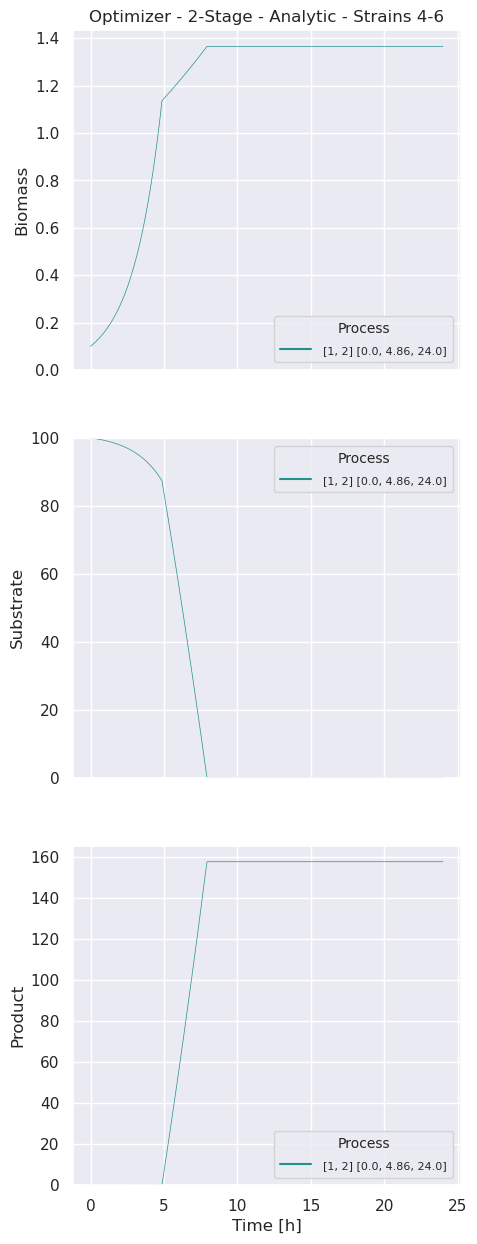

In [ ]:
log_dataframe_2Stage_4to6_num = pd.DataFrame(OptimizerNumeric_2Stage_4to6.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerNumeric_2Stage_4to6_best = msp.do_opt_to_df(  df=log_dataframe_2Stage_4to6_num,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerNumeric_2Stage_4to6_best = msp.do_convert(opt_res=OptimizerNumeric_2Stage_4to6_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerNumeric_2Stage_4to6_best)

msp.do_custom_plot(df=df_OptimizerNumeric_2Stage_4to6_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 2-Stage - Analytic - Strains 4-6",
                   events=[event_sub0])

## Two-Stage fermentation (all modules) - Analytic

In [ ]:
%%time

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]


## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=10000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerAnalytic_2Stage_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_analytic,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.analytic_option
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerAnalytic_2Stage_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerAnalytic_2Stage = algo_ihs.evolve(population(OptimizerAnalytic_2Stage_Prob, size=10, seed=12345)) 

## Optional, save results:
#msp.do_save(OptimizerAnalytic_2Stage, './Results/Computer_Stg2_ana_opt_All.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350064       0.998849         16.421        9.39983              0              0       -9.54862
    501       0.382064       0.561694        3.17459       0.148158              0              0       -19.9513
   1001       0.414064       0.315864              0              0              0              0       -20.0279
   1501       0.446064       0.177623              0              0              0              0       -20.0279
   2001       0.478064      0.0998849              0              0              0              0       -20.0279
   2501       0.510064      0.0561694     0.00586676     0.00044447              0              0       -20.0283
   3001       0.542064      0.0315864      0.0100462    0.000531103              0              0       -20.0289
   3501       0.574064      0.0177623              0              0              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.607, 24.0]","[1, 5]",7.704,1.321,0.001,154.305,2,20.029,1.543,1.543


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

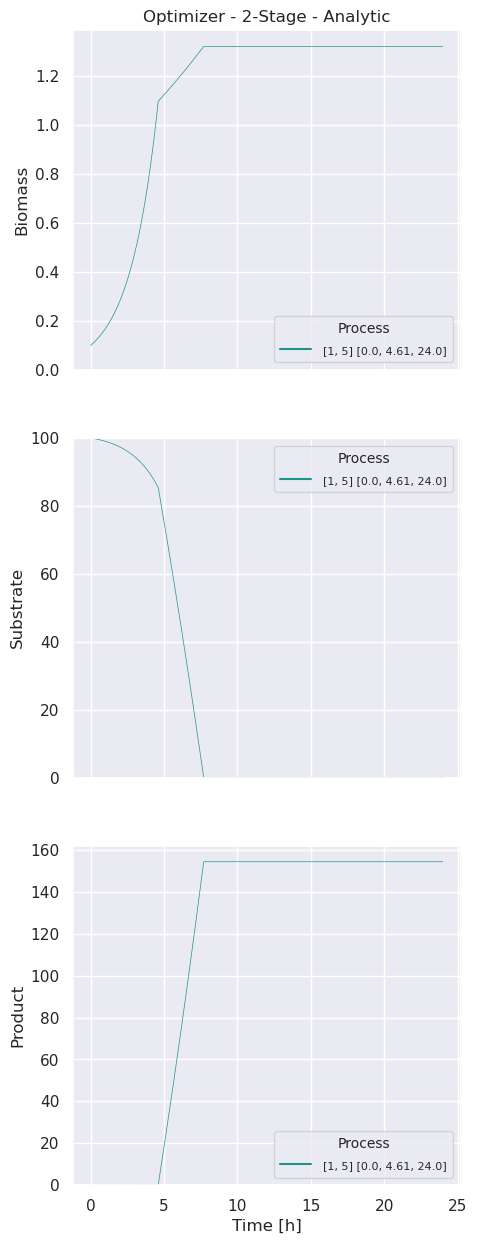

In [ ]:
log_dataframe_2Stage = pd.DataFrame(OptimizerAnalytic_2Stage.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerAnalytic_2Stage_best = msp.do_opt_to_df(  df=log_dataframe_2Stage,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerAnalytic_2Stage_best = msp.do_convert(opt_res=OptimizerAnalytic_2Stage_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerAnalytic_2Stage_best)

msp.do_custom_plot(df=df_OptimizerAnalytic_2Stage_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 2-Stage - Analytic",
                   events=[event_sub0])

## Two-Stage fermentation (all modules) - Numeric

In [ ]:
%%time

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]


## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=10000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(500)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerNumeric_2Stage_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=2,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.numeric_option,
            events=[event_sub0]
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerNumeric_2Stage_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerNumeric_2Stage = algo_ihs.evolve(population(OptimizerNumeric_2Stage_Prob, size=10, seed=12345))

## Optional, save results:
#msp.do_save(OptimizerNumeric_2Stage, './Results/Computer_Stg2_num_opt_All.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350064       0.998849         16.421        9.39977              0              0       -9.54855
    501       0.382064       0.561694         3.0398       0.231282              0              0       -20.0276
   1001       0.414064       0.315864              0              0              0              0       -20.0276
   1501       0.446064       0.177623              0              0              0              0       -20.0276
   2001       0.478064      0.0998849              0              0              0              0       -20.0276
   2501       0.510064      0.0561694     0.00586676    0.000530183              0              0       -20.0281
   3001       0.542064      0.0315864      0.0100462     0.00058515              0              0       -20.0287
   3501       0.574064      0.0177623              0              0              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.607, 24.0]","[1, 5]",7.703,1.322,0.0,154.293,2,20.029,1.543,1.543


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

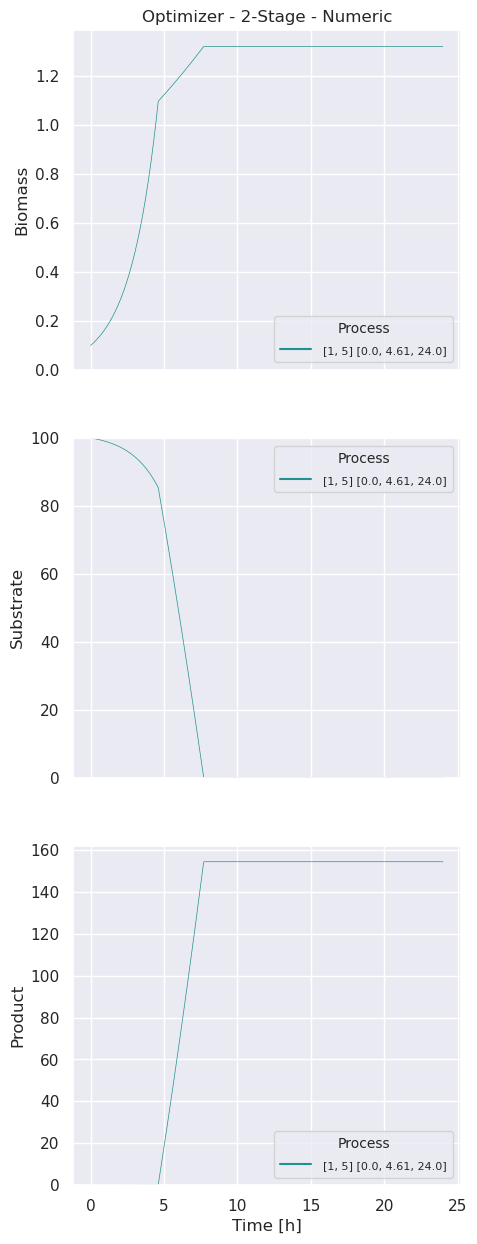

In [ ]:
log_dataframe_2Stage_num = pd.DataFrame(OptimizerNumeric_2Stage.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerNumeric_2Stage_best = msp.do_opt_to_df(  df=log_dataframe_2Stage_num,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerNumeric_2Stage_best = msp.do_convert(opt_res=OptimizerNumeric_2Stage_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerNumeric_2Stage_best)

msp.do_custom_plot(df=df_OptimizerNumeric_2Stage_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 2-Stage - Numeric",
                   events=[event_sub0])

## Three-Stage fermentation  - Analytic
(could be seen as strain comparison)

### Ecolac

In [8]:
%%time
models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt]

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest]

## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(5000)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerAnalytic_3Stage_1to3_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_analytic,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.analytic_option,
            events=None
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerAnalytic_3Stage_1to3_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerAnalytic_3Stage_1to3 = algo_ihs.evolve(population(OptimizerAnalytic_3Stage_1to3_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerAnalytic_3Stage_1to3, './Results/Computer_Stg3_ana_opt_1to3.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.48651              0              0       -4.48651
   5001       0.414013       0.316155              0              0              0              0       -16.5781
  10001       0.478013       0.099977       0.462249              0              0              0       -16.5781
  15001       0.542013      0.0316155       0.671141    7.10543e-15              0              0       -16.5781
  20001       0.606013      0.0099977              0              0              0              0       -16.5781
  25001       0.670013     0.00316155      0.0455742              0              0              0       -16.5781
  30001       0.734013     0.00099977    1.04237e-05     4.8281e-10              0              0       -16.5781
  35001       0.798013    0.000316155              0              0              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.632, 10.409, 24.0]","[1, 2, 2]",8.331,1.798,0.001,138.107,2,16.578,1.381,1.381


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

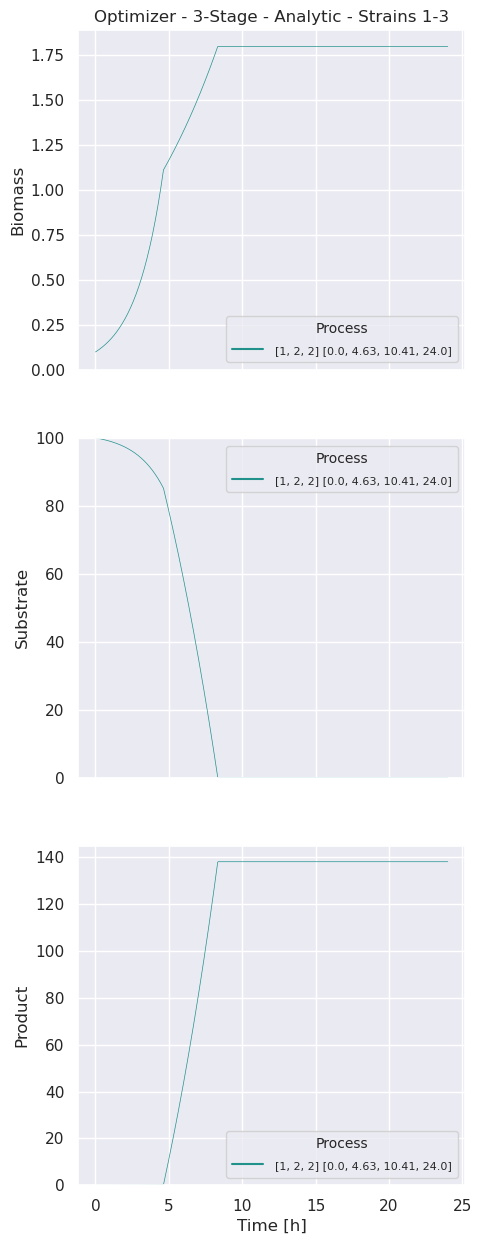

In [9]:
log_dataframe_3Stage_1to3 = pd.DataFrame(OptimizerAnalytic_3Stage_1to3.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerAnalytic_3Stage_1to3_best = msp.do_opt_to_df(  df=log_dataframe_3Stage_1to3,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerAnalytic_3Stage_1to3_best = msp.do_convert(opt_res=OptimizerAnalytic_3Stage_1to3_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerAnalytic_3Stage_1to3_best)

msp.do_custom_plot(df=df_OptimizerAnalytic_3Stage_1to3_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 3-Stage - Analytic - Strains 1-3",
                   events=[event_sub0])

### EcolacATPase

Modules below showing 1, 2, 3 but are if taken all modules in order 4, 5, 6

In [10]:
%%time
models_analytic = [LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]

models_numeric = [      LC_aerob_growth,
                        LC_anaerob_growth, 
                        LC_anaerob_growth_arrest]


## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(5000)  # output best performing each 50th generation



## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerAnalytic_3Stage_4to6_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_analytic,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.analytic_option
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerAnalytic_3Stage_4to6_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerAnalytic_3Stage_4to6 = algo_ihs.evolve(population(OptimizerAnalytic_3Stage_4to6_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerAnalytic_3Stage_4to6, './Results/Computer_Stg3_ana_opt_4to6.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.55281              0              0       -4.55281
   5001       0.414013       0.316155        10.7794              0              0              0       -19.9194
  10001       0.478013       0.099977        4.75072    7.10543e-15              0              0       -19.9197
  15001       0.542013      0.0316155              0              0              0              0       -19.9197
  20001       0.606013      0.0099977       0.127718    3.55271e-15              0              0       -19.9197
  25001       0.670013     0.00316155              0              0              0              0       -19.9197
  30001       0.734013     0.00099977              0              0              0              0       -19.9197
  35001       0.798013    0.000316155      0.0192814    3.55271e-15              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.86, 6.679, 24.0]","[1, 2, 2]",7.926,1.366,0.001,157.875,3,19.92,1.579,1.579


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

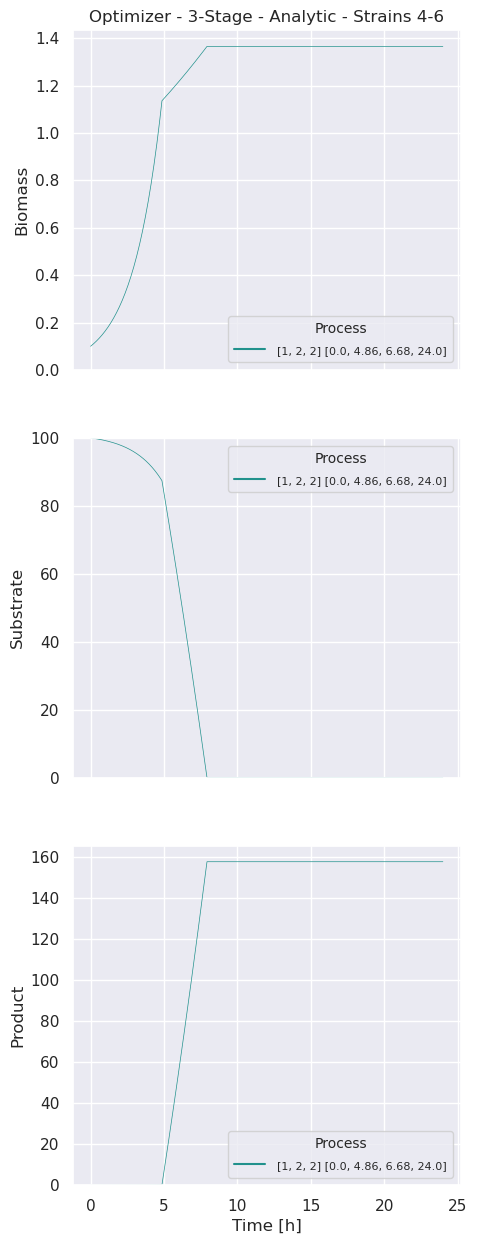

In [11]:
log_dataframe_3Stage_4to6 = pd.DataFrame(OptimizerAnalytic_3Stage_4to6.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerAnalytic_3Stage_4to6_best = msp.do_opt_to_df(  df=log_dataframe_3Stage_4to6,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerAnalytic_3Stage_4to6_best = msp.do_convert(opt_res=OptimizerAnalytic_3Stage_4to6_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerAnalytic_3Stage_4to6_best)

msp.do_custom_plot(df=df_OptimizerAnalytic_3Stage_4to6_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 3-Stage - Analytic - Strains 4-6",
                   events=[event_sub0])

## Three-Stage fermentation  - Numeric
(could be seen as strain comparison)

### Ecolac 

In [12]:
%%time
models_numeric = [  WT_aerob_growth,
                    WT_anaerob_growth, 
                    WT_anaerob_growth_arrest]

## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(5000)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerNumeric_3Stage_1to3_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.numeric_option,
            events=[event_sub0]
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerNumeric_3Stage_1to3_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerNumeric_3Stage_1to3 = algo_ihs.evolve(population(OptimizerNumeric_3Stage_1to3_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerNumeric_3Stage_1to3, './Results/Computer_Stg3_num_opt_1to3.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.48651              0              0       -4.48651
   5001       0.414013       0.316155              0              0              0              0        -16.578
  10001       0.478013       0.099977              0              0              0              0        -16.578
  15001       0.542013      0.0316155              0              0              0              0        -16.578
  20001       0.606013      0.0099977        14.7089    1.62937e-06              0              0        -16.578
  25001       0.670013     0.00316155              0              0              0              0        -16.578
  30001       0.734013     0.00099977              0              0              0              0        -16.578
  35001       0.798013    0.000316155              0              0              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.631, 6.833, 24.0]","[1, 2, 2]",8.331,1.798,0.0,138.111,3,16.578,1.381,1.381


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

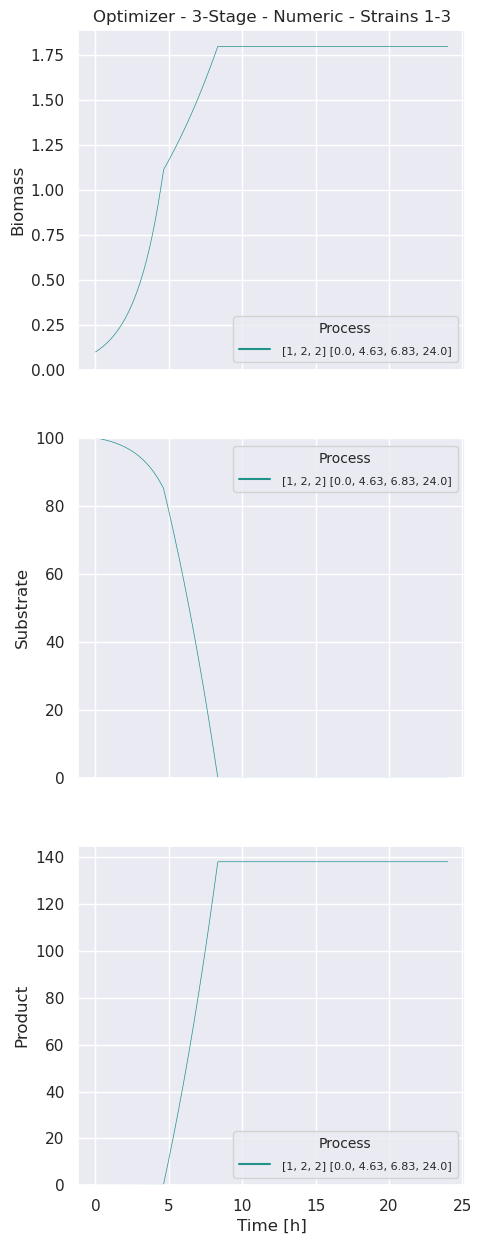

In [13]:
log_dataframe_3Stage_1to3_num = pd.DataFrame(OptimizerNumeric_3Stage_1to3.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerNumeric_3Stage_1to3_best = msp.do_opt_to_df(  df=log_dataframe_3Stage_1to3_num,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerNumeric_3Stage_1to3_best = msp.do_convert(opt_res=OptimizerNumeric_3Stage_1to3_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerNumeric_3Stage_1to3_best)

msp.do_custom_plot(df=df_OptimizerNumeric_3Stage_1to3_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 3-Stage - Numeric - Strains 1-3",
                   events=[event_sub0])

### EcolacATPase 

In [14]:
%%time
models_numeric = [  LC_aerob_growth,
                    LC_anaerob_growth, 
                    LC_anaerob_growth_arrest]

## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=50000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(5000)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerNumeric_3Stage_4to6_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.numeric_option,
            events=[event_sub0]
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerNumeric_3Stage_4to6_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerNumeric_3Stage_4to6 = algo_ihs.evolve(population(OptimizerNumeric_3Stage_4to6_Prob, size=10, seed=12345))  

## Optional, save results:
#msp.do_save(OptimizerNumeric_3Stage_4to6, './Results/Computer_Stg3_num_opt_4to6.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350013        0.99977        25.5675        4.55281              0              0       -4.55281
   5001       0.414013       0.316155        6.64351    0.000210844              0              0       -19.9195
  10001       0.478013       0.099977       0.668417     5.7745e-06              0              0       -19.9196
  15001       0.542013      0.0316155              0              0              0              0       -19.9196
  20001       0.606013      0.0099977              0              0              0              0       -19.9196
  25001       0.670013     0.00316155              0              0              0              0       -19.9196
  30001       0.734013     0.00099977              0              0              0              0       -19.9196
  35001       0.798013    0.000316155              0              0              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 4.861, 6.858, 24.0]","[1, 2, 2]",7.925,1.366,0.0,157.873,3,19.92,1.579,1.579


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

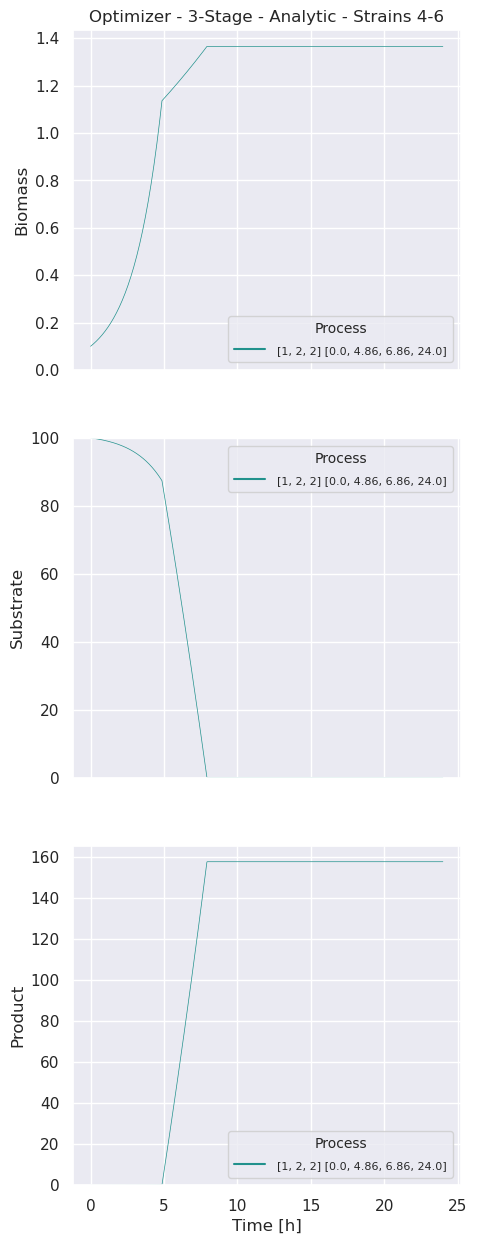

In [15]:
log_dataframe_3Stage_4to6_num = pd.DataFrame(OptimizerNumeric_3Stage_4to6.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerNumeric_3Stage_4to6_best = msp.do_opt_to_df(  df=log_dataframe_3Stage_4to6_num,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerNumeric_3Stage_4to6_best = msp.do_convert(opt_res=OptimizerNumeric_3Stage_4to6_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerNumeric_3Stage_4to6_best)

msp.do_custom_plot(df=df_OptimizerNumeric_3Stage_4to6_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 3-Stage - Analytic - Strains 4-6",
                   events=[event_sub0])

## Three-Stage fermentation (all modules)  - Analytic

In [16]:
%%time
models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]


## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=100000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(10000)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerAnalytic_3Stage_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_analytic,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.analytic_option
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerAnalytic_3Stage_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerAnalytic_3Stage = algo_ihs.evolve(population(OptimizerAnalytic_3Stage_Prob, size=10, seed=12345)) 

## Optional, save results:
#msp.do_save(OptimizerAnalytic_3Stage, './Results/Computer_Stg3_ana_opt_All.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350006       0.999885        30.0108        9.74465              0              0       -9.74465
  10001       0.414006       0.316191              0              0              0              0       -20.0287
  20001       0.478006      0.0999885              0              0              0              0        -20.092
  30001       0.542006      0.0316191              0              0              0              0        -20.092
  40001       0.606006     0.00999885              0              0              0              0        -20.092
  50001       0.670006     0.00316191     0.00176283    3.24459e-08              0              0        -20.092
  60001       0.734006    0.000999885    0.000869656     5.0508e-09              0              0        -20.092
  70001       0.798006    0.000316191    0.000870288    1.86564e-08              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 3.275, 4.72, 24.0]","[1, 4, 5]",7.765,1.357,0.001,156.003,3,20.092,1.56,1.56


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

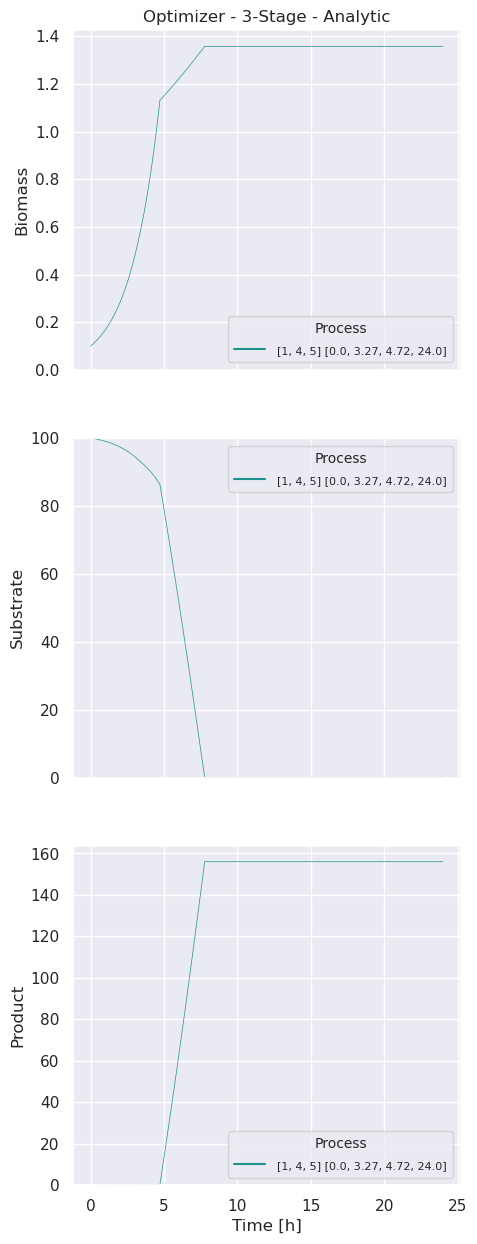

In [17]:
log_dataframe_3Stage = pd.DataFrame(OptimizerAnalytic_3Stage.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerAnalytic_3Stage_best = msp.do_opt_to_df(  df=log_dataframe_3Stage,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerAnalytic_3Stage_best = msp.do_convert(opt_res=OptimizerAnalytic_3Stage_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerAnalytic_3Stage_best)

msp.do_custom_plot(df=df_OptimizerAnalytic_3Stage_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 3-Stage - Analytic",
                   events=[event_sub0])

## Three-Stage fermentation (all modules)  - Numeric

In [18]:
%%time

models_numeric = [WT_aerob_growth,
                 WT_anaerob_growth, 
                 WT_anaerob_growth_arrest,
                 LC_aerob_growth,
                 LC_anaerob_growth, 
                 LC_anaerob_growth_arrest]

models_analytic = [WT_aerob_growth_analyt,
                 WT_anaerob_growth_analyt, 
                 WT_anaerob_growth_arrest_analyt,
                 LC_aerob_growth_analyt,
                 LC_anaerob_growth_analyt, 
                 LC_anaerob_growth_arrest_analyt]


## 1.) was done right at the start of the notebook under "Objective function for optimization"

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=100000, seed=12345))  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(10000)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
OptimizerNumeric_3Stage_Prob = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            indexes=[X, S, P],
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=volprod, 
            optmod="max",
            calc_option=msp.numeric_option,
            events=[event_sub0]
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance
OptimizerNumeric_3Stage_Prob.c_tol = 1e-3

## 4.) Starting the optimization
OptimizerNumeric_3Stage = algo_ihs.evolve(population(OptimizerNumeric_3Stage_Prob, size=10, seed=12345))

## Optional, save results:
#msp.do_save(OptimizerNumeric_3Stage, './Results/Computer_Stg3_num_opt_All.pickle')


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1       0.350006       0.999885        30.0108        9.74457              0              0       -9.74457
  10001       0.414006       0.316191              0              0              0              0       -20.0285
  20001       0.478006      0.0999885              0              0              0              0       -20.0918
  30001       0.542006      0.0316191              0              0              0              0       -20.0919
  40001       0.606006     0.00999885              0              0              0              0       -20.0919
  50001       0.670006     0.00316191              0              0              0              0       -20.0919
  60001       0.734006    0.000999885      0.0177788    6.60878e-06              0              0       -20.0919
  70001       0.798006    0.000316191      0.0035628    4.54677e-06              0             

No constraints found.


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 3.281, 4.72, 24.0]","[1, 4, 5]",7.764,1.357,0.0,155.996,3,20.092,1.56,1.56


<module 'matplotlib.pyplot' from '/home/jbauer/miniconda3/envs/twostage/lib/python3.8/site-packages/matplotlib/pyplot.py'>

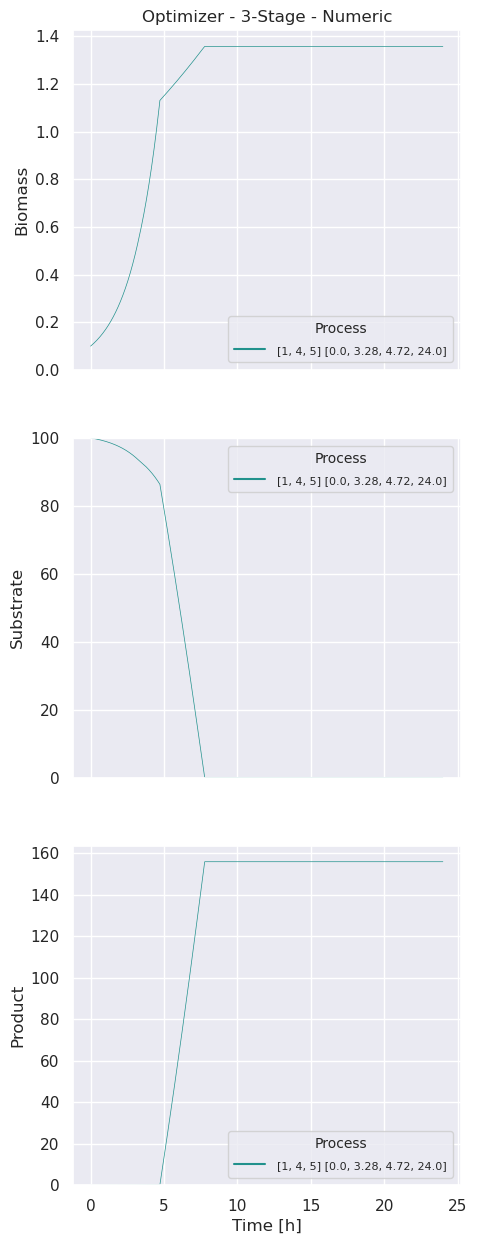

In [19]:
log_dataframe_3Stage_num = pd.DataFrame(OptimizerNumeric_3Stage.problem.extract(decorator_problem).dv_log)[1:] 

OptimizerNumeric_3Stage_best = msp.do_opt_to_df(  df=log_dataframe_3Stage_num,     # log dataframe from optimization
                                                        n_best=1)                         # Number of best performing processes that are returned

df_OptimizerNumeric_3Stage_best = msp.do_convert(opt_res=OptimizerNumeric_3Stage_best, 
                                                       models_num=models_numeric, 
                                                       t_start=0, 
                                                       t_end=24, 
                                                       s=s,
                                                       indexes=[X, S, P],
                                                       events=[event_sub0])

display(df_OptimizerNumeric_3Stage_best)

msp.do_custom_plot(df=df_OptimizerNumeric_3Stage_best, 
                   models_num=models_numeric, 
                   s=s, 
                   title="Optimizer - 3-Stage - Numeric",
                   events=[event_sub0])